In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2025-06-07 16:22:09.799035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749313330.002737      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749313330.064198      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


In [4]:
print("GPUs Available:", tf.config.list_physical_devices('GPU'))
print("Is GPU being used?", tf.test.is_gpu_available())

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Is GPU being used? True


I0000 00:00:1749313562.902466      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749313562.903264      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 96
CHANNELS = 3
EPOCHS = 50
NUM_CLASSES = 7

In [6]:
output_dir = '/kaggle/input/augmented-face-images/augmented_face_images'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    output_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def one_hot_map(image, label):
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

dataset = dataset.map(one_hot_map)

Found 62833 files belonging to 7 classes.


I0000 00:00:1749313608.212857      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749313608.213068      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 96, 96, 3)
[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


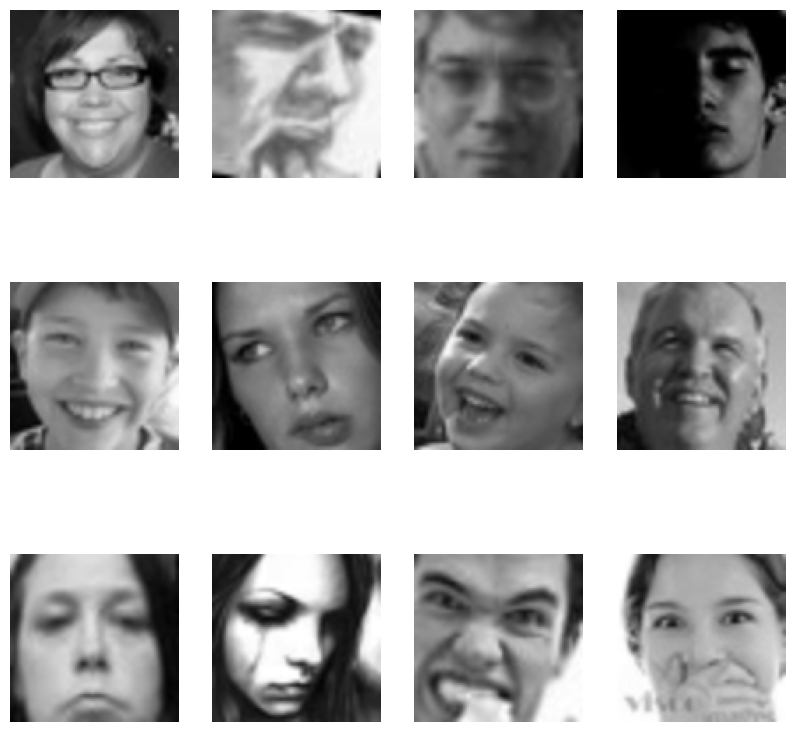

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np

# Parameters
num_classes = 7
input_shape = (96, 96, 3)
batch_size = BATCH_SIZE
epochs = EPOCHS

# Load pretrained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Build the full model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)

model = build_model(base_model)

# Compile model without F1Score metric (to avoid tensorflow-addons issues)
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC()
    ]
)

# Train the model
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Evaluate on test dataset (loss + other metrics except F1)
results = model.evaluate(test_ds)
loss, accuracy, precision, recall, auc = results

# Predict on test dataset for manual F1 calculation
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())   # Convert one-hot to label indices
    y_pred.extend(tf.argmax(preds, axis=1).numpy())    # Predicted class indices

# Calculate macro F1 score manually with sklearn
f1 = f1_score(y_true, y_pred, average='macro')

# Print all metrics
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score (macro): {f1 * 100:.2f}%")
print(f"AUC: {auc * 100:.2f}%")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1749313855.335087     105 service.cc:148] XLA service 0x7d78780adff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749313855.336026     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749313855.336047     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749313859.974692     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1571 ━━━━━━━━━━━━━━━━━━━━ 60:26:03 139s/step - accuracy: 0.3438 - auc: 0.6672 - loss: 1.9885 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1749313878.141862     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1571/1571 ━━━━━━━━━━━━━━━━━━━━ 324s 118ms/step - accuracy: 0.4413 - auc: 0.7985 - loss: 1.5131 - precision: 0.6601 - recall: 0.2298 - val_accuracy: 0.3691 - val_auc: 0.7557 - val_loss: 1.6405 - val_precision: 0.6369 - val_recall: 0.1754
Epoch 2/50
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.5729 - auc: 0.8916 - loss: 1.1287 - precision: 0.7433 - recall: 0.3959 - val_accuracy: 0.5775 - val_auc: 0.8964 - val_loss: 1.1040 - val_precision: 0.7251 - val_recall: 0.4383
Epoch 3/50
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.6298 - auc: 0.9175 - loss: 0.9889 - precision: 0.7670 - recall: 0.4823 - val_accuracy: 0.5596 - val_auc: 0.8814 - val_loss: 1.1852 - val_precision: 0.6871 - val_recall: 0.4281
Epoch 4/50
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.6708 - auc: 0.9359 - loss: 0.8722 - precision: 0.7871 - recall: 0.5497 - val_accuracy: 0.6370 - val_auc: 0.9198 - val_loss: 0.9807 - val_precision: 0.7650 - val_recall: 0.5134
Epoch 5/50
1571/1571 ━

In [14]:
from tensorflow import keras
model.save('/kaggle/working/face_model.h5')